In [0]:
import json
import math
import random
import matplotlib.pyplot as plt
import time

In [0]:
T_MIN = 0.0001
T_INIT = 100
MAX_ITERATIONS = 10000
ANNEALING_RATE = 0.01

In [0]:
# read dataset and take n most popular cities
def prepare_data(filename, n):  
  with open(filename, "r") as read_file:
      data = json.load(read_file)
  for i, item in enumerate(data):
    # drop broken sample
    if item.get('Город') == 'Иннополис':
      del data[i]
  sorted_data = sorted(data, key=lambda k: int(k.get('Население', 0)), reverse=True)
  data = sorted_data[:30]
  return data

In [282]:
data = prepare_data('datasets/city.json', 30)
print('Resulting dataset length: '+ str(len(data)))
for item in data:
  print(item)

Resulting dataset length: 30
{'Индекс': '101000', 'Тип региона': 'г', 'Регион': 'Москва', 'Тип района': '', 'Район': '', 'Тип города': '', 'Город': '', 'Тип н/п': '', 'Н/п': '', 'Код КЛАДР': '7700000000000', 'Код ФИАС': '0c5b2444-70a0-4932-980c-b4dc0d3f02b5', 'Уровень по ФИАС': '1: регион', 'Признак центра района или региона': '0', 'Код ОКАТО': '45000000000', 'Код ОКТМО': '', 'Код ИФНС': '7700', 'Часовой пояс': 'UTC+3', 'Широта': '55.7538789', 'Долгота': '37.6203735', 'Федеральный округ': 'Центральный', 'Население': '11514330'}
{'Индекс': '190000', 'Тип региона': 'г', 'Регион': 'Санкт-Петербург', 'Тип района': '', 'Район': '', 'Тип города': '', 'Город': '', 'Тип н/п': '', 'Н/п': '', 'Код КЛАДР': '7800000000000', 'Код ФИАС': 'c2deb16a-0330-4f05-821f-1d09c93331e6', 'Уровень по ФИАС': '1: регион', 'Признак центра района или региона': '0', 'Код ОКАТО': '40000000000', 'Код ОКТМО': '', 'Код ИФНС': '7800', 'Часовой пояс': 'UTC+3', 'Широта': '59.939125', 'Долгота': '30.3158225', 'Федеральный о

In [0]:
# decrease temp at each iteration
def decrease_temp(T_INIT, iter):
  return T_INIT * ANNEALING_RATE / iter


# probability of transition
def transition_prob(dE, T):
  return math.exp(-dE/T)


# trainsition condition
def is_transition(prob):
  u = random.uniform(0, 1)
  if u <= prob:
    return True
  return False


# new candidate generation
def generate_state_cand(data):
  a = random.randint(0, len(data) - 1)
  b = a
  while (b == a):
    b = random.randint(0, len(data) - 1)
  #print(a, b)
  if (a > b):
    sublist = data[b:a+1].copy()
    sublist.reverse()
    return data[:b] + sublist + data[a+1:]
  else:
    sublist = data[a:b+1].copy()
    sublist.reverse()
    return data[:a] + sublist + data[b+1:]


# function for energy calculation
def calculate_E(state):
  energy = 0
  for i in range(len(state)-1):
    lat_a_radians = float(state[i].get('Широта'))*math.pi/180
    long_a_radians = float(state[i].get('Долгота'))*math.pi/180
    lat_b_radians = float(state[i+1].get('Широта'))*math.pi/180
    long_b_radians = float(state[i+1].get('Долгота'))*math.pi/180
    dist = math.acos(math.sin(lat_a_radians) * math.sin(lat_b_radians) + \
      math.cos(lat_a_radians) * math.cos(lat_b_radians) * math.cos(long_a_radians - long_b_radians))
    energy += dist * 6371
  # calculate first and last distance to "close the chain"
  lat_a_radians = float(state[0].get('Широта'))*math.pi/180
  long_a_radians = float(state[0].get('Долгота'))*math.pi/180
  lat_b_radians = float(state[len(state)-1].get('Широта'))*math.pi/180
  long_b_radians = float(state[len(state)-1].get('Долгота'))*math.pi/180
  dist = math.acos(math.sin(lat_a_radians) * math.sin(lat_b_radians) + \
    math.cos(lat_a_radians) * math.cos(lat_b_radians) * math.cos(long_a_radians - long_b_radians))
  energy += dist * 6371

  return energy


In [0]:
def SimulatedAnnealing(data, T_INIT, T_MIN):
  # initialize data
  state = data.copy()
  # shuffle data
  random.shuffle(state)
  T = T_INIT
  energy_arr = []
  for i in range(MAX_ITERATIONS):
    # calculate energy for current state and for candidate state
    curr_energy = calculate_E(state)
    cand = generate_state_cand(state)
    cand_energy = calculate_E(cand)
    energy_arr.append(cand_energy)
    print('Iteration number ' + str(i+1) + ', Temperature value: ' + str(T) \
        + ', Energy value: ' + str(cand_energy)) 
    if cand_energy < curr_energy:
      curr_energy = cand_energy
      state = cand
    else:
      # calcualte transition probability
      prob = transition_prob(cand_energy - curr_energy, T)
      if is_transition(prob) == True:
        curr_energy = cand_energy
        state = cand
    # decrease tempearture (cooling)
    T = decrease_temp(T_INIT, i + 1)

    if (T <= T_MIN):
      print('End by temperature lower limit. Iteration number: ' + str(i))
      break
  return state, energy_arr

In [277]:
start = time.time()
result_state, energy_arr = SimulatedAnnealing(data, T_INIT, T_MIN)
finish = time.time()
print('Time taken to converge: ' + str(finish - start))
names = []
for item in result_state:
  if item.get('Город') != '':
    names.append(item.get('Город'))
  else:
    names.append(item.get('Регион'))
print(names)
print(calculate_E(result_state))

Iteration number 1, Temperature value: 100, Energy value: 57248.515172947904
Iteration number 2, Temperature value: 1.0, Energy value: 57267.32257108858
Iteration number 3, Temperature value: 0.5, Energy value: 57842.42572486546
Iteration number 4, Temperature value: 0.3333333333333333, Energy value: 57285.091739651536
Iteration number 5, Temperature value: 0.25, Energy value: 57514.8070492812
Iteration number 6, Temperature value: 0.2, Energy value: 57392.94373960904
Iteration number 7, Temperature value: 0.16666666666666666, Energy value: 61908.67558828539
Iteration number 8, Temperature value: 0.14285714285714285, Energy value: 57234.23991449777
Iteration number 9, Temperature value: 0.125, Energy value: 58614.516902130956
Iteration number 10, Temperature value: 0.1111111111111111, Energy value: 58606.22139029163
Iteration number 11, Temperature value: 0.1, Energy value: 61908.6755882854
Iteration number 12, Temperature value: 0.09090909090909091, Energy value: 57842.42572486546
Ite

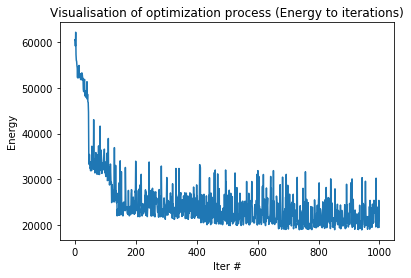

Result energy value: 18898.130706340828


In [252]:
iterations = list(range(0, len(energy_arr)))
plt.plot(iterations, energy_arr)
plt.xlabel('Iter #')
plt.ylabel('Energy')
plt.title('Visualisation of optimization process (Energy to iterations)')
plt.show()
print('Result energy value: ' + str(calculate_E(result_state)))